# Image Classification
In this demo notebook we build a simple deep neural network to classify an image as one of the following:


In [1]:
# Import required libraries
import os
import uuid
import shutil
import json
#from botocore.client import Config
#import ibm_boto3
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

327 ..total number of images ( files)

In [2]:
!ls data


eb1compress  healthyv1	lb1compress  smpl.JPG


## Build the Model

We start with a [MobileNetV2](https://arxiv.org/abs/1801.04381) architecture as the backbone [pretrained feature extractor](https://github.com/tensorflow/models/tree/master/research/slim/nets/mobilenet). We then add a couple of dense layers and a softmax layer to perfom the classification. We freeze the MobileNetV2 backbone with weights trained on ImageNet dataset and only train the dense layers and softmax layer that we have added.

In [3]:
base_model=tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 1
x=tf.keras.layers.Dense(256,activation='relu')(x) #dense layer 2
preds=tf.keras.layers.Dense(3,activation='softmax')(x) #final layer with softmax activation

model=tf.keras.Model(inputs=base_model.input,outputs=preds)


In [4]:
#Freeze layers from MobileNetV2 backbone (not to be trained)
for layer in base_model.layers:
    layer.trainable=False

In [5]:
#Prepare the training dataset as a data generator object
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('data',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=10,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 326 images belonging to 3 classes.


### Using Adam, categorical_crossentropy and accuracy as optimization method, loss function and metrics, respectively

In [6]:
# Build the model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
#model.summary()

## Train the model

In [7]:
#tf.random.set_random_seed(1)
tf.random.set_seed(1)
#model.fit(X, y, epochs=150, batch_size=10)



In [8]:
step_size_train=5
#log_file = model.fit_generator(generator=train_generator,
#                   steps_per_epoch=step_size_train,
#                   epochs=4)
model.fit(train_generator, epochs=5, batch_size=10)

Epoch 1/5
33/33 [==============================] - 26s 587ms/step - loss: 0.3319 - accuracy: 0.8436
Epoch 2/5
33/33 [==============================] - 19s 565ms/step - loss: 0.1110 - accuracy: 0.9540
Epoch 3/5
33/33 [==============================] - 19s 573ms/step - loss: 0.0434 - accuracy: 0.9847
Epoch 4/5
33/33 [==============================] - 20s 613ms/step - loss: 0.0416 - accuracy: 0.9785
Epoch 5/5
33/33 [==============================] - 20s 597ms/step - loss: 0.0232 - accuracy: 0.9877


## Figure of Training Loss and Accuracy

## Model Performance

Here we perform inference on some sample data points to determine the performance of the model

In [9]:
# Mapping labels 
label_map = (train_generator.class_indices)

In [10]:
label_map

{'eb1compress': 0, 'healthyv1': 1, 'lb1compress': 2}

In [11]:
# Creating a sample inference function
def prediction(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    preds = model.predict(x)
    #print('Predictions', preds)
    
    for pred, value in label_map.items():    
        if value == np.argmax(preds):
            print('Predicted class is:', pred)
            print('With a confidence score of: ', np.max(preds))
    
    return np.argmax(preds)

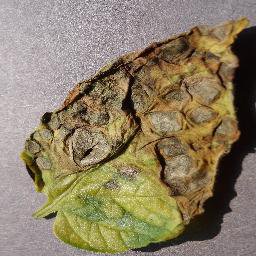

In [13]:
image = Image.open("smpl.JPG")
image

In [14]:
#performing inference on above image
prediction('smpl.JPG', model)

Predicted class is: eb1compress
With a confidence score of:  0.9987129


0

In [15]:
#model.save("jj3Model.h5")
tf.keras.models.save_model(model,'/home/mistral/jpynb/Belarus/jj6Model.h5')

/home/mistral/tmp/jkDL/lib/python3.6/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
